In [30]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib
from tqdm import tqdm
from typing import List, Dict
import calpgs
import glob
from natsort import natsorted
import tempfile
import subprocess
from typing import Dict
import itertools
import submitit
from admix.data import quantile_normalize

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Why R^2 did decrease with PC1, while coverage is ok when using the same interval for every individual

In [4]:
!calpgs group-r2 --df out/model/LDL-other/const-1-none.test_info.tsv --y pheno --pred cal_pred --predstd cal_predstd --group PC1,AGE,SEX --out ./tmp --n-bootstrap 10 --n-subgroup 5

2022-06-23 20:45.58 [info     ] Received parameters: 
group-r2
  --df=out/model/LDL-other/const-1-none.test_info.tsv
  --y=pheno
  --pred=cal_pred
  --group=('PC1', 'AGE', 'SEX')
  --out=./tmp
  --predstd=cal_predstd
  --cor=pearson
  --n_subgroup=5
  --n_bootstrap=10
  --seed=1234
2022-06-23 20:45.58 [info     ] 53096/53096 rows without missing values at pheno and cal_pred
2022-06-23 20:45.58 [info     ] Converting column 'PC1' to 5 quintiles
Bootstrapping: 100%|████████████████████████████| 10/10 [00:00<00:00, 47.33it/s]
2022-06-23 20:45.58 [info     ] Converting column 'AGE' to 5 quintiles
Bootstrapping: 100%|████████████████████████████| 10/10 [00:00<00:00, 51.73it/s]


In [76]:
df = pd.read_csv(
    "out/model/height-white/const-1-none.test_info.tsv", sep="\t", index_col=0
)
# df["pheno"] = quantile_normalize(df["pheno"])

In [77]:
df["PC1_q"] = pd.qcut(df["PC1"], q=5, duplicates="drop")

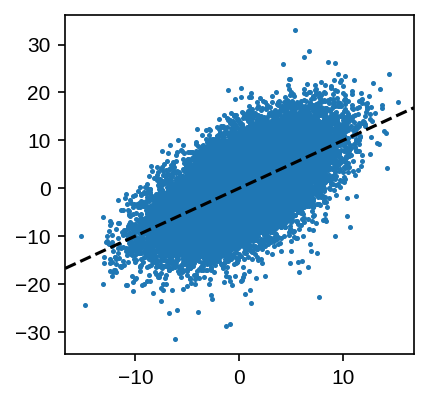

In [78]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df["cal_pred"], df["pheno"], s=2)
ax.axline((0, 0), slope=1, zorder=10, color="black", ls="--")

In [89]:
df_tmp = df[df.cal_pred.between(7, 12)]

In [90]:
df_res = calpgs.summarize_pred(
    df_tmp,
    y_col="pheno",
    pred_col="cal_pred",
    predstd_col="cal_predstd",
)

In [91]:
df_res

r2           0.050992
std(y)       5.503889
std(pred)    1.130919
coverage     0.877289
length       8.114876
dtype: float64

In [6]:
df

,pheno,pred,predstd,AGE,SEX,log_BMI,PC1,PC2,PC3,PC4,income,cal_pred,cal_predstd
indiv,,,,,,,,,,,,,
4990322,0.993551,-0.242581,1.0,56,1,3.36239,-12.0606,3.97896,-2.044830,1.052680,1.00000,-0.190526,0.803409
3826556,0.339832,0.250152,1.0,60,0,3.24405,-11.7598,4.55327,-3.065660,-1.423370,1.00000,0.237313,0.803409
1921643,-0.096886,0.070404,1.0,42,1,3.61345,74.3213,-136.91700,-69.304600,-7.595590,1.73205,0.081238,0.803409
1363796,-1.357004,-0.309005,1.0,67,0,3.51036,-11.2860,1.74577,-0.384031,1.190150,1.41421,-0.248201,0.803409
1213142,-0.370052,-0.272539,1.0,44,0,3.26164,-13.7973,3.13182,-3.398460,0.281756,2.00000,-0.216538,0.803409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5338654,0.414635,0.016688,1.0,52,1,3.19867,-11.3504,6.08486,-1.872450,-0.036727,1.73205,0.034597,0.803409
1527506,0.221419,0.100854,1.0,44,1,3.26420,16.5262,-26.62060,13.473300,-34.823600,1.73205,0.107678,0.803409
2208752,-0.203189,0.127336,1.0,63,0,3.19875,-10.0395,2.76310,0.833009,-5.430250,1.73205,0.130672,0.803409


In [1]:
from quantile_forest import RandomForestQuantileRegressor
from sklearn import datasets
X, y = datasets.fetch_california_housing(return_X_y=True)
qrf = RandomForestQuantileRegressor()
qrf.fit(X, y)
y_pred = qrf.predict(X, quantiles=[0.025, 0.5, 0.975])

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import matplotlib.pyplot as plt

In [7]:
y_pred

array([[3.659  , 4.526  , 5.00001],
       [3.3564 , 3.585  , 5.00001],
       [3.49074, 3.521  , 5.00001],
       ...,
       [0.59427, 0.923  , 1.03557],
       [0.61398, 0.847  , 1.32398],
       [0.59515, 0.894  , 1.2965 ]])

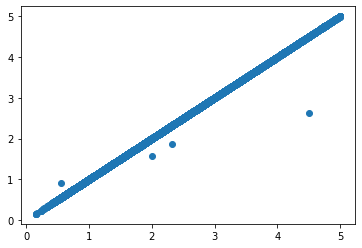

In [9]:
plt.scatter(y, y_pred[:, 1])

In [2]:
y_pred

array([[3.659  , 4.526  , 5.00001],
       [3.3564 , 3.585  , 5.00001],
       [3.49074, 3.521  , 5.00001],
       ...,
       [0.59427, 0.923  , 1.03557],
       [0.61398, 0.847  , 1.32398],
       [0.59515, 0.894  , 1.2965 ]])